## Toy MHD and divergence cleaning 


We made a code to check the divergence cleaning strategies discussed in: https://www.overleaf.com/read/phmtkqtkxwjr#baf932

In this version we add the hyperbolic divergence cleaning. Since we are using periodic boundary conditions we don't expect much improvement, because the waves will revolve around,  only the one coming from the damping term. 


### The evolution equations are:

$$
\partial_t B^i = \nabla_j (v^j B^i - v^i B^j) + \kappa \nabla^i (\nabla_j B^j)
$$
for the parabolic case, and

\begin{align*}
\partial_t B^i &= \nabla_j (v^j B^i - v^i B^j) + \nabla^i ψ \\
\partial_t ψ &= c^2 \nabla_j B^j - τψ
\end{align*}


In [1]:
using Plots
using SummationByPartsOperators
using LinearAlgebra
using ArraysOfArrays
using Base.Threads
using Revise
using JLD2
#import Pkg; Pkg.add("WriteVTK")
using WriteVTK

includet("../PIC/PIC-1D/aux_functions/aux_functions_grid.jl")
includet("../PIC/PIC-1D/aux_functions/aux_functions_E-B.jl")
includet("../PIC/PIC-1D/aux_functions/aux_functions_RHS.jl")
includet("toy_MHD_auxfunctions.jl")

Setting the box and the grid coordinates.

In [2]:
J = (200,200)
Box = (0.0,1.0,0.0,1.0)
dx = differentials(Box,J)
const D = 2

xv = [(i-1)*dx[1] for i in 1:J[1]]
yv = [(i-1)*dx[2] for i in 1:J[2]];

The finite differences. 

In [3]:
Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=4, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=4, xmin=Box[3], xmax=Box[4], N=J[2])
Δx = dissipation_operator(Dx;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
Δy = dissipation_operator(Dy;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
σx = 0.0 #dissipation strength
σy = 0.0 #dissipation strength

0.0

### Build initial data and velocity field.

#### Velocity field

In [4]:

x0 = [0.5,0.5]
fv(x,y,k) = sin(k[1]*x)*sin(k[2]*y)
```
bump of radius r and smoothness p around the point x0
```
function fp(x,y,x0,r,p) 
    r20 = r^2
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return (r20 - r2)^p/r20^p
    else
        return 0.0
    end
end
```
gradient of bump of radius r and smoothness p around the point x0
```
function grad_fp(x,y,x0,r,p)
    r20 = r^2
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return -2*p*[(x-x0[1]),(y-x0[2])]*(r20 - r2)^(p-1)/r20^p
    else
        return [0.0, 0.0]
    end
end

function polynomial_bump(x,y,p)
    return x^p*(x-1)^p*y^p*(y-1)^p*2^4p
end

#poly = [polynomial_bump(x,y,4) for x in xv, y in yv]

#possible V's 

# Inidat 0
#For really periodic cases we use this one: 

# a sinusoidal one:
#k1 = 2π*[1,1]
#V = [-(l-2)*cos(k1[1]*xv[i]) + (l-1)*cos(k1[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];

# Inidat 1
#For one of compact support we use this one: This has problems when used with PINNs because it used `if` statements.
# one from the gradient of a bump function. Because the CFL condition we don't want it to be too big.
#grad_Fp = [grad_fp(xv[i],yv[j],x0,0.45,8)[l] for l in 1:D, i in 1:J[1], j in 1:J[2]];
#V = -0.1*grad_Fp # with 0.1 it is about 1/2 at maximum. 

# Inidat 2
#To use one that is zero at the boundary we use the following:
# RUN UP TO T=0.4
#=
V = zeros(2,J[1],J[2]);
for i in 1:J[1]
    mul!(view(V,2,i,:), Dy, view(poly,i,:))
end
for j in 1:J[2]
    mul!(view(V,1,:,j), Dx, view(poly,:,j))
end

V = V / maximum(abs.(V))
=#

#Inidat 3
#Another V which has outgoing flow so no boundary conditions are needed
# RUN UP TO T=4.0
r0 = 0.16
r = [(xv[i]-0.5)^2+(yv[j]-0.5)^2 for i in 1:J[1], j in 1:J[2]];
V = [-(l-2)*(xv[j]-0.5)*r[i,j]*(r[i,j]-r0) + (l-1)*(yv[i]-0.5)*r[i,j]*(r[i,j]-r0) for l in 1:2, i in 1:J[1], j in 1:J[2]];
V = V / maximum(abs.(V)) * 0.5;


Plot velocity field

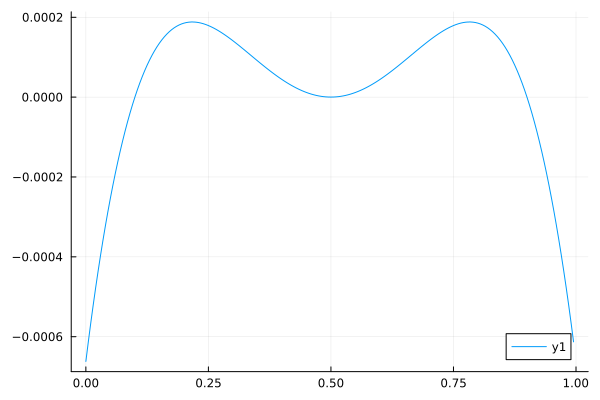

In [5]:
plot(xv,view(V,1,:,J[2]÷2))

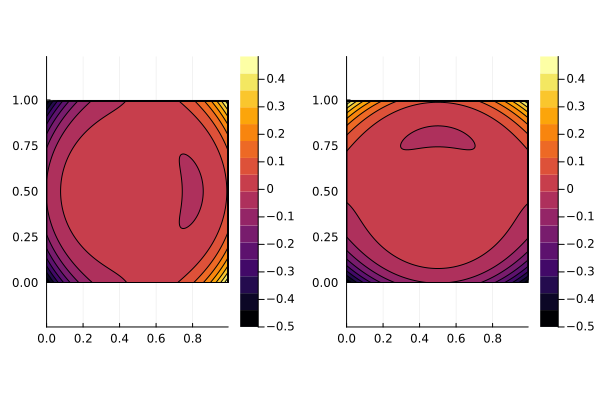

In [6]:
px = plot(yv,xv,V[1,:,:]
, linetype = :contourf
, aspect_ratio = 1
)
py = plot(yv,xv,V[2,:,:]
, linetype = :contourf
, aspect_ratio = 1
)
plot(px,py)

#### Initial Magnetic Field

In [7]:

#initial magnetic field

B = zeros(2,J[1],J[2]);
#possible B's
#k2 = 2π*[2,2]
#B = [(l-2)*k2[2]*sin(k2[1]*xv[i])*cos(k2[2]*yv[j]) + (l-1)*k2[1]*cos(k2[1]*xv[i])*sin(k2[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
# the following is not working well, the divergence in not zero
#B[1,:,:] = [ (y^3)*(y-1)^3*(2y-1)*(x)^4*(x-1)^4*2^16 for x in xv for y in yv]
#B[2,:,:] = [ -(x^3)*(x-1)^3*(2x-1)*(y)^4*(y-1)^4*2^16 for x in xv for y in yv]

#we also put a violation of div(B)=0 using the same function

eps = 0.0 #10.0^(-5)

poly = [polynomial_bump(x,y,4) for x in xv, y in yv]
@show size(poly)
for i in 1:J[1]
    mul!(view(B,1,i,:), Dy, view(poly,i,:))
    mul!(view(B,2,i,:), Dy, view(poly,i,:), eps)
end
for j in 1:J[2]
    mul!(view(B,2,:,j), -Dx, view(poly,:,j), 1.0)
    mul!(view(B,1,:,j), Dx, view(poly,:,j), eps, 1.0)
end

# pure frequency error 
k2 = 2π*[10,10]
B_error_k = 10^(-5)*[(l-2)*cos(k2[1]*xv[i])*cos(k2[2]*yv[j]) + (l-1)*cos(k2[1]*xv[i])*cos(k2[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
B .+= B_error_k;

size(poly) = (200, 200)


Plot initial magnetic field

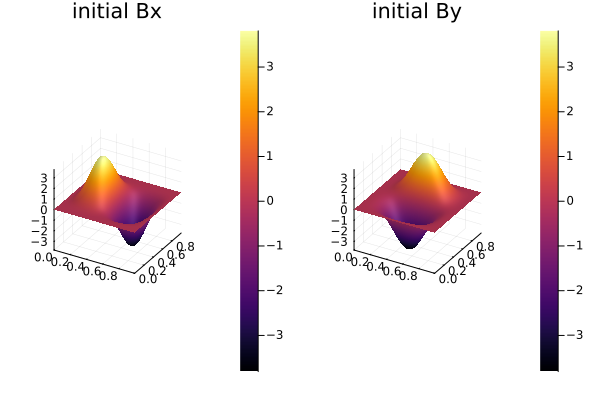

In [8]:
plot(surface(yv,xv,B[1,:,:], title="initial Bx"), surface(yv,xv,B[2,:,:], title="initial By"))

Check the maximum initial constraint violation.

In [9]:
@show maximum(abs.(Div(B,Dx,Dy,J)))

maximum(abs.(Div(B, Dx, Dy, J))) = 0.0006281169060577962


0.0006281169060577962

Plot the initial constraint violation. Notice that it is of high frequency.

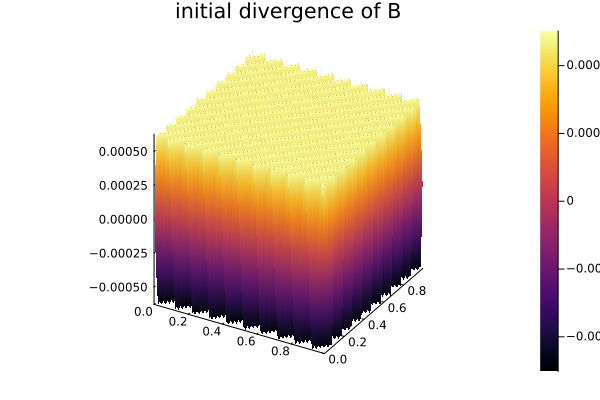

In [10]:
surface(yv,xv,Div(B,Dx,Dy,J), title="initial divergence of B")

Plot the divergence of the velocity field, some times it is important to see where the divergence of the magnetic field will grow.

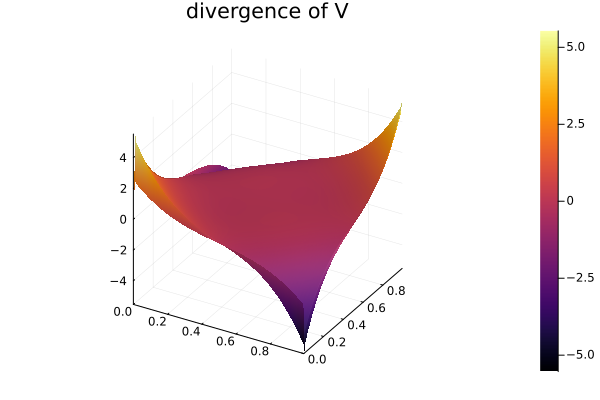

In [11]:
surface(yv,xv,Div(V,Dx,Dy,J), title="divergence of V")

Create the union of evolutionary fields. And location for its time derivatives.

In [12]:
u = Vector{Float64}(undef,(D+1)*J[1]*J[2]); #the last component is psi
du = Vector{Float64}(undef,(D+1)*J[1]*J[2]);

u .= 0.0;
du .= 0.0;

U = reshape(u,D+1,J[1],J[2]);

### Set the method:

In [13]:
#=
hyperbolic = false
parabolic = false
no_div_cleaning = false
hyperbolic = true
#parabolic = true
no_div_cleaning = true
=#
#method = :hyperbolic
method = :parabolic
#method = :no_div_cleaning
@show method

methods = [:no_div_cleaning, :hyperbolic, :parabolic, :mixed]

method = :parabolic


4-element Vector{Symbol}:
 :no_div_cleaning
 :hyperbolic
 :parabolic
 :mixed

In [14]:
function evolve(u,du,V, B_init, method, time_interval, M, par)
    J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du = par
    U[1:D,:,:] .= copy(B_init)
    U[D+1,:,:] .= 0.0 #psi

    if method == :hyperbolic
        κ = 0.0
        c2 = 1.0
        τ = 1.0
    elseif method == :parabolic
        κ = minimum(dx)/2
        c2 = 0.0
        τ = 0.0
    elseif method == :no_div_cleaning
        κ = 0.0
        c2 = 0.0
        τ = 0.0
    elseif method == :mixed
        κ = minimum(dx)/2
        c2 = 1.0
        τ = 1.0
    else
        error("method must be :hyperbolic, :parabolic or :no_div_cleaning")
    end
    (t_i, t_f) = time_interval
    dt = (t_f - t_i)/M

    par = (J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du)

    @show κ, c2, τ, dt/maximum(dx)
    #set initial values
    Energy = Array{Float64,1}(undef,M+1)
    Div_B_max = Array{Float64,1}(undef,M+1)
    Div_B_L2 = Array{Float64,1}(undef,M+1)
    tt = Array{Float64,1}(undef,M+1)
    @show Energy[1] = get_Energy(u,J,Box)
    @show Div_B_max[1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
    @show Div_B_L2[1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))
    tt[1] = t_i
    t = t_i
    
    for i in 1:M
        #=
        if method == :hyperbolic || method == :no_div_cleaning
            RK4_Step!(F_hyp!, u, 0.0, dt, par)
        elseif method == :parabolic
            RK4_Step!(F_par!, u, 0.0, dt, par)
        end
        =#
        RK4_Step!(F_total!, u, 0.0, dt, par)

        t = t + dt
        tt[i+1] = t
    
        Energy[i+1] = get_Energy(u,J,Box)
        Div_B_max[i+1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
        Div_B_L2[i+1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))

        #println("t = $t")
        #println("Energy = $(get_Energy(u,J,Box))")
        #println("DivB = $(maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))))")
    
end
    return u, Energy, Div_B_max, Div_B_L2, tt
end

evolve (generic function with 1 method)

In [15]:
#method = :hyperbolic
method = :parabolic
#method = :no_div_cleaning
time_interval = (0.0, 4.0)
M = 800
κ = minimum(dx)/2
c2 = 1.0
τ = 1.0
par = (J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du)
u_final, Energy, Div_B_max, Div_B_L2, tt = evolve(u,du,V,B,method, time_interval, M,par)

(κ, c2, τ, dt / maximum(dx)) = (0.0025, 0.0, 0.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.486387887436572
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.0006281169060577962
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 0.0004441457200049368


([-0.004697455115909073, 0.004697455115910144, 0.0, -0.030340797061885024, -0.01853890087261462, 0.0, -0.0027291312221279698, 0.007210473490088989, 0.0, -0.02991820411917092  …  0.0, -0.015141148149975834, -0.02884635566566121, 0.0, -0.03649383577351091, -0.04831375151790533, 0.0, 0.0067345111757018674, -0.006734511175700313, 0.0], [3.486387887436572, 3.4863882668575883, 3.4863894051313067, 3.48639130226056, 3.4863939582495034, 3.486397373104641, 3.48640154683413, 3.4864064794481027, 3.486412170958599, 3.4864186213792885  …  3.7342695481695154, 3.7349158073595836, 3.7355629785575926, 3.7362110621586297, 3.736860058561225, 3.737509968168768, 3.7381607913895096, 3.7388125286378098, 3.7394651803341823, 3.740118746906214], [0.0006281169060577962, 0.0005691213467051703, 0.000515666916832469, 0.0004672331672681551, 0.00042334853290237895, 0.00038358574018282354, 0.0003475576473142006, 0.00031491347450129936, 0.0002853353887373178, 0.00025853540949860587  …  1.7053025658242404e-13, 1.56319401

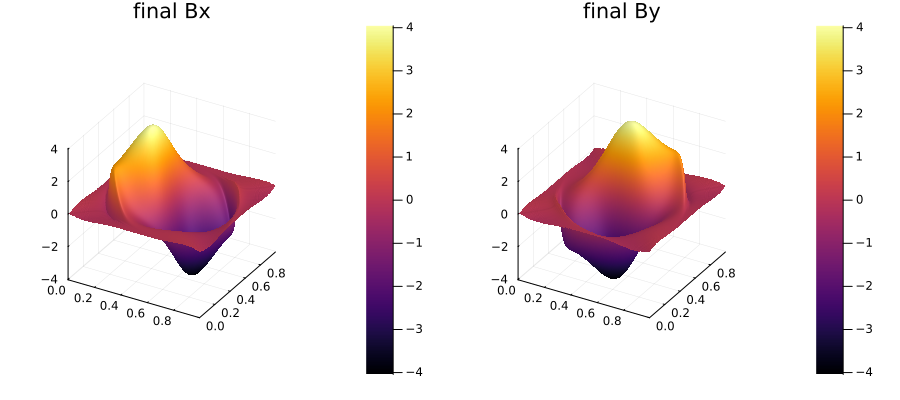

In [16]:
pBx = surface(yv,xv,reshape(u_final,(D+1,J...))[1,:,:], title="final Bx")
pBy = surface(yv,xv,reshape(u_final,(D+1,J...))[2,:,:], title="final By")

plot(pBx, pBy, size=(900,400))

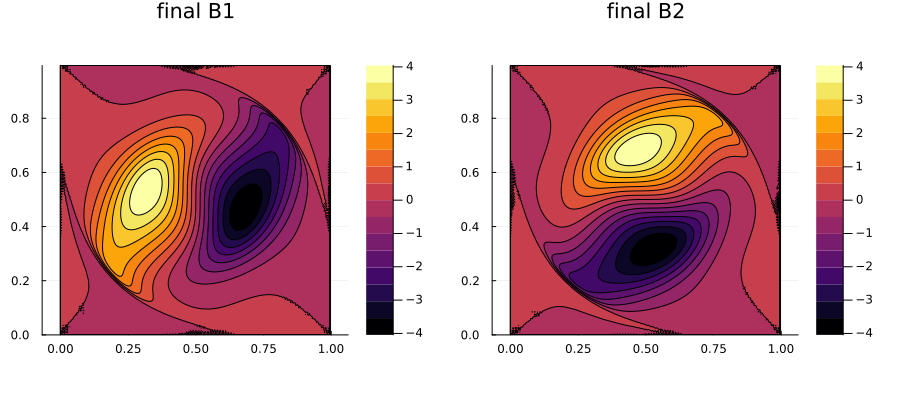

In [17]:
ps = []
for i in 1:2
    p1 = plot(yv, xv, reshape(u_final,(D+1,J...))[i,:,:], title="final B$i"
        ,linetype = :contourf
        #st = :surface,
        , aspect_ratio = 1)
    push!(ps, p1)
end

plot(ps[1], ps[2], layout = (1,2), size= (900,400))#linetype = :contourf, 
        

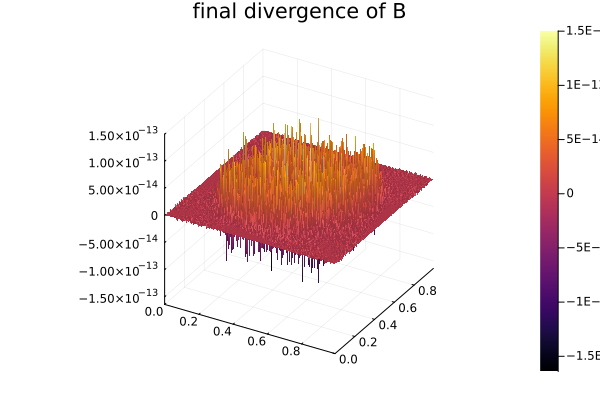

In [18]:
surface(yv,xv,Div(reshape(u_final,(D+1,J...))[1:D, :, :],Dx,Dy,J), title="final divergence of B")

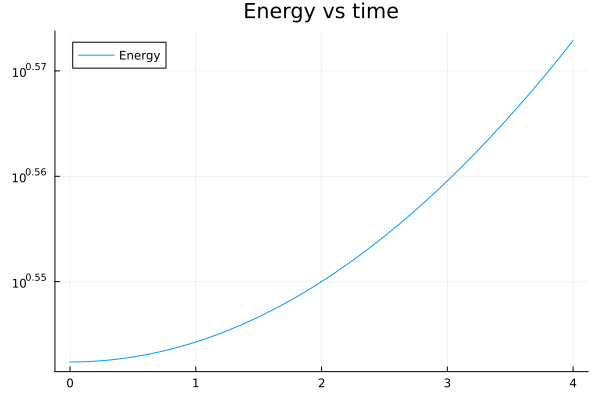

In [19]:
plot(tt,Energy, yaxis=:log, title="Energy vs time", label="Energy")

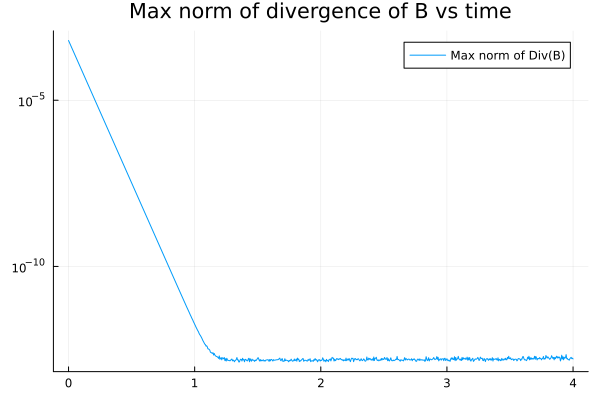

In [20]:
plot(tt, Div_B_max, yaxis=:log, title="Max norm of divergence of B vs time", label="Max norm of Div(B)")

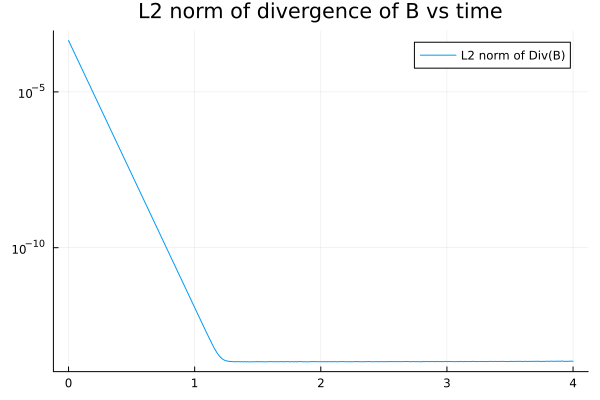

In [21]:
plot(tt, Div_B_L2, yaxis=:log, title="L2 norm of divergence of B vs time", label="L2 norm of Div(B)")

## Now all methods together

Evolving with method = no_div_cleaning
(κ, c2, τ, dt / maximum(dx)) = (0.0, 0.0, 0.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.486387887436572
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.0006281169060577962
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 0.0004441457200049368
Evolving with method = hyperbolic
(κ, c2, τ, dt / maximum(dx)) = (0.0, 1.0, 1.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.486387887436572
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.0006281169060577962
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 0.0004441457200049368
Evolving with method = parabolic
(κ, c2, τ, dt / maximum(dx)) = (0.0025, 0.0, 0.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.486387887436572
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.00062811

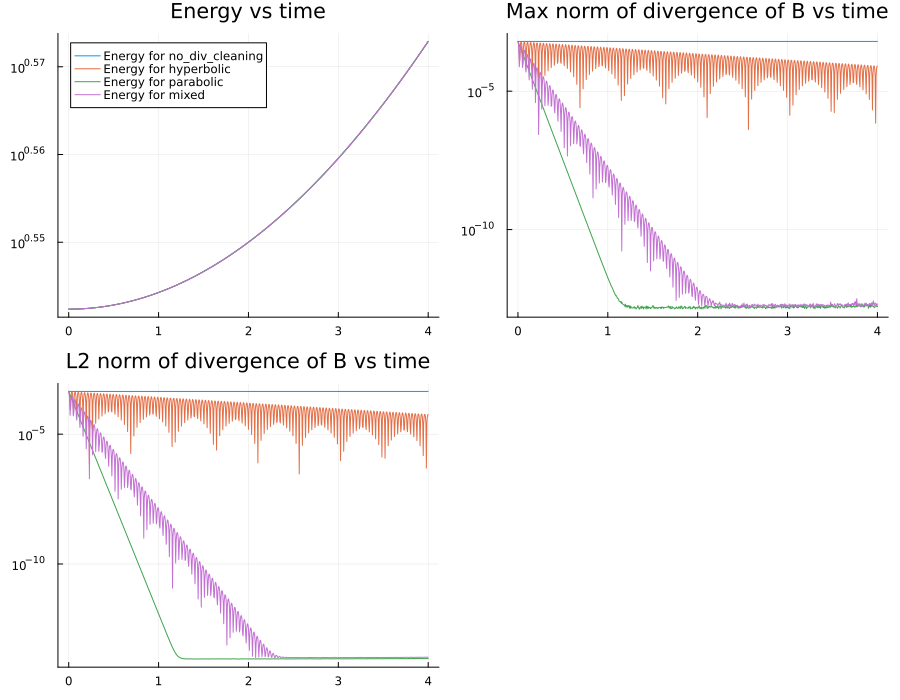

In [22]:
p_E = plot()
p_Div_max = plot()
p_Div_L2 = plot()

for method in methods
    println("Evolving with method = $method")
    u_final, Energy, Div_B_max, Div_B_L2, tt = evolve(u,du,V,B,method, time_interval, M,par)
    plot!(p_E,tt,Energy, yaxis=:log, title="Energy vs time", label="Energy for $method")
    plot!(p_Div_max,tt, Div_B_max, yaxis=:log, title="Max norm of divergence of B vs time", label="Max norm of Div(B) for $method", legend=:false)
    plot!(p_Div_L2,tt, Div_B_L2, yaxis=:log, title="L2 norm of divergence of B vs time", label="L2 norm of Div(B) for $method", legend=:false)
end

plot(p_E, p_Div_max, p_Div_L2, layout = (2,2), size=(900,700))
#savefig("comparison_div_cleaning_methods_error_k20_inidat_3.png")

![try_1 comparison](comparison_div_cleaning_methods.png)